In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler # this is used to sample the hyperparameters

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',600)
pd.set_option('display.max_rows',450)

sns.set(style="whitegrid")

## Data Loading

In [71]:
train_data=pd.read_csv('train.csv')
train_data.name='Train Dataset' # setting the name of the dataset
test_data=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')
original_data=pd.read_csv('ObesityDataSet.csv')
original_data.name='Original Dataset'



In [72]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [73]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20758.0,10378.500000,5992.462780,0.00,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [75]:
original_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [76]:
original_data.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


## Visualizing Null Values

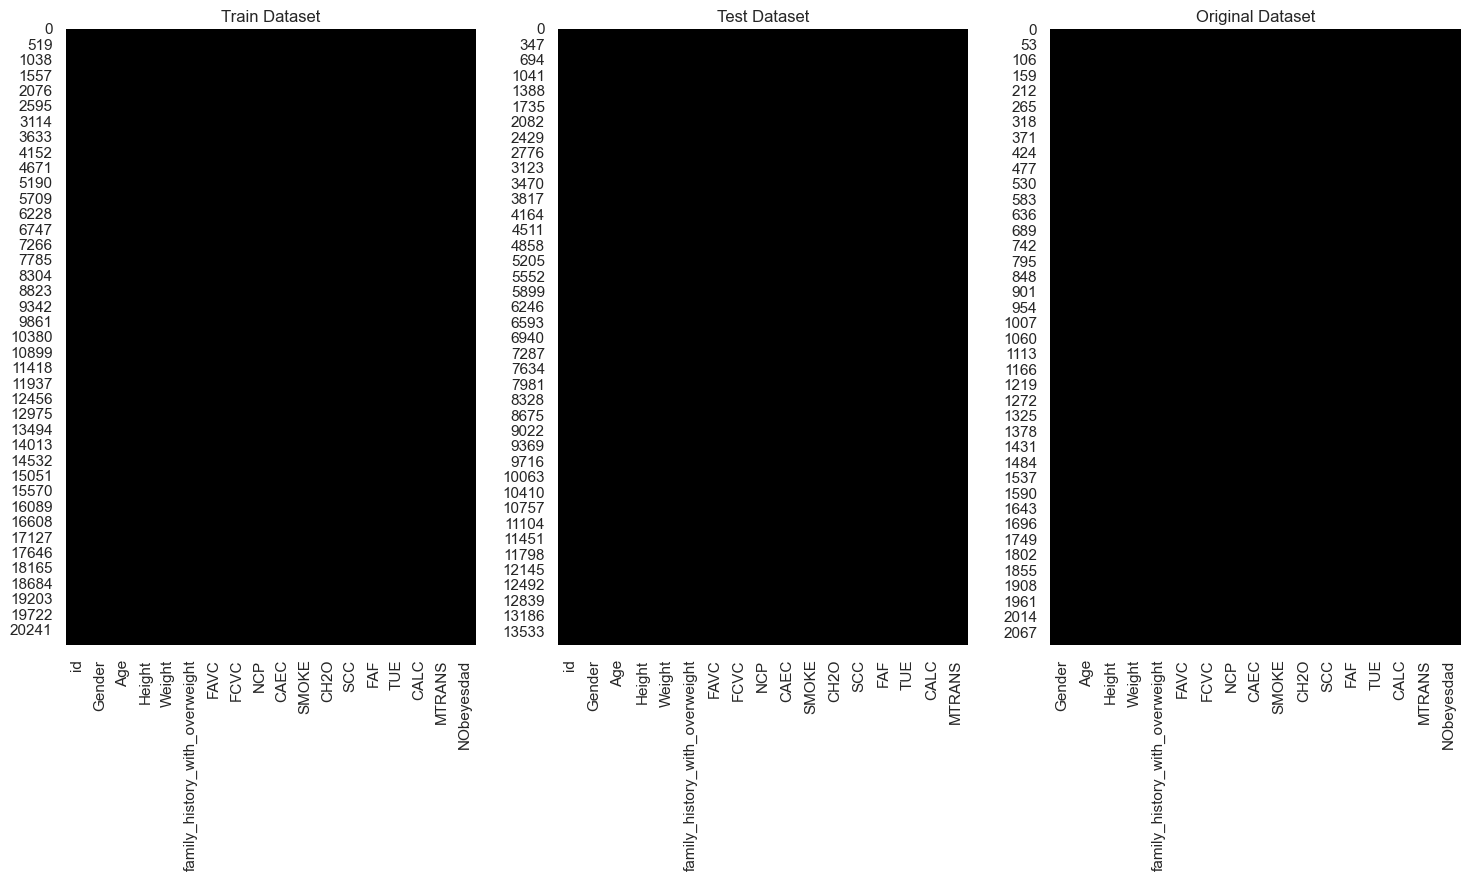

In [77]:
# create a subplot of 1 row and 3 columns
fig,axes=plt.subplots(1,3,figsize=(18,8))

# visualize null values in train set
sns.heatmap(train_data.isna(),cmap='gray',cbar=False,ax=axes[0])
axes[0].set_title('Train Dataset')
# visualize numll values in the test set
sns.heatmap(test_data.isnull(),cmap='gray',cbar=False,ax=axes[1])
axes[1].set_title('Test Dataset')
# visualize numll values in the original set
sns.heatmap(original_data.isnull(),cmap='gray',cbar=False,ax=axes[2])
axes[2].set_title('Original Dataset')

# plt.tight_layout() # avoid overlapping of subplots
plt.show()

In [78]:
train_data.isnull().sum().sum(),test_data.isnull().sum().sum(),original_data.isnull().sum().sum()

(0, 0, 0)

## Extracting variable types

In [79]:
def get_variable_types(df):
    categorical_vars=[]
    continuous_vars=[]
    for var in df.columns:
        if df[var].dtype=='object':
            categorical_vars.append(var)
        else:
            continuous_vars.append(var)
    return categorical_vars,continuous_vars

categorical_vars,continuous_vars=get_variable_types(train_data)
continuous_vars.remove('id'),categorical_vars.remove('NObeyesdad')

print(f"Continuous vars: {continuous_vars}\n")
print(f"Categorical vars: {categorical_vars}")

Continuous vars: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Categorical vars: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


## Plotting Distribution of Categorical columns

In [99]:
def plot_distribution(df,target):
    # calculate value counts
    value_counts=df[target].value_counts()

    # create a figure with 2 subplots
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

    # barplot on first subplot
    sns.barplot(x=value_counts.index,y=value_counts,ax=ax1)
    ax1.set_xlabel(target,fontsize=12)
    ax1.set_ylabel('Count',fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right',fontsize=10) # ha: horizontal alignment

    # add data labels above each bar
    for index,value in enumerate(value_counts):
        ax1.text(index,value+int(value*0.01),str(value),ha='center',fontsize=10) # value+20: to place the label above the bar

    # Pie plot on second subplot
    ax2.pie(value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('viridis',len(value_counts))) # autopct: add precentage on the pie plot
    ax2.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle

    # Main title for the figure
    fig.suptitle(f'Comparison of {target} Distribution in ({df.name})',fontsize=18,fontweight='bold')

    # adjust the layout and display the figure
    plt.tight_layout()
    plt.show()



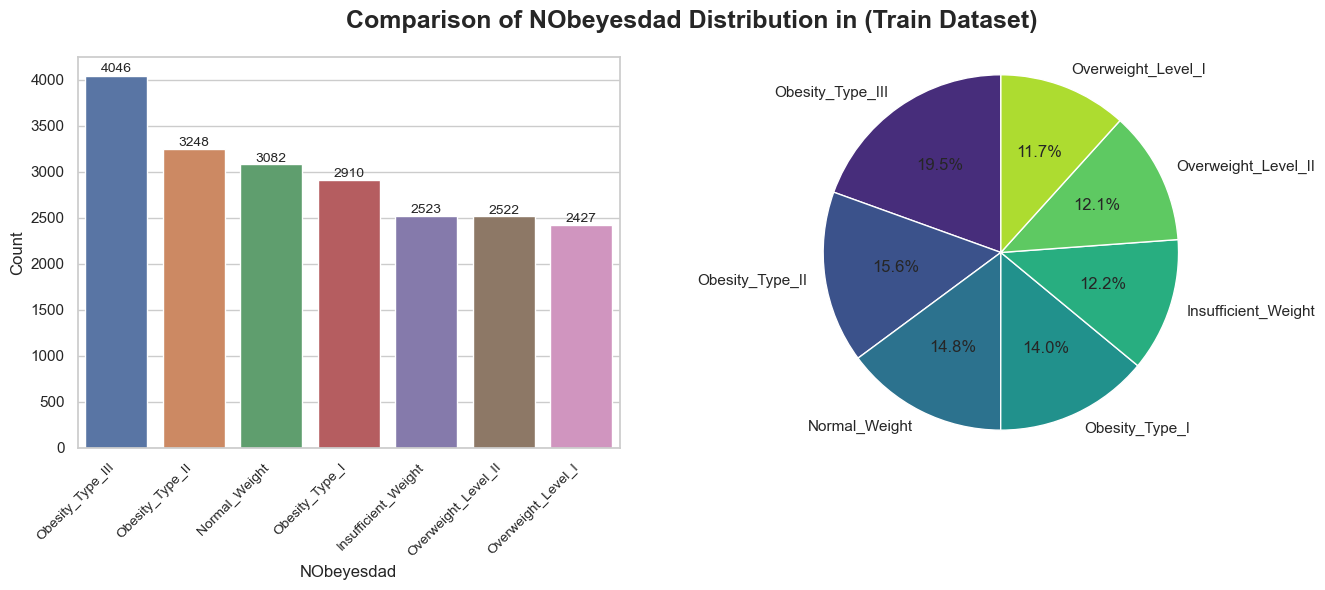

In [100]:
plot_distribution(train_data,'NObeyesdad')

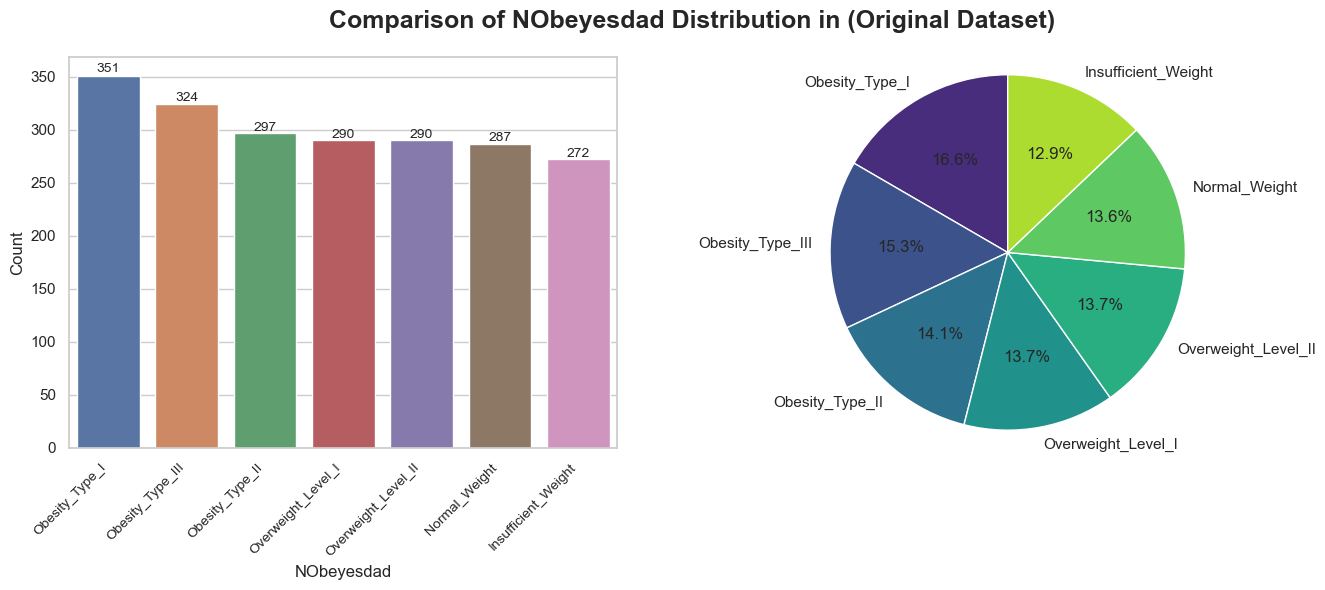

In [101]:
plot_distribution(original_data,'NObeyesdad')

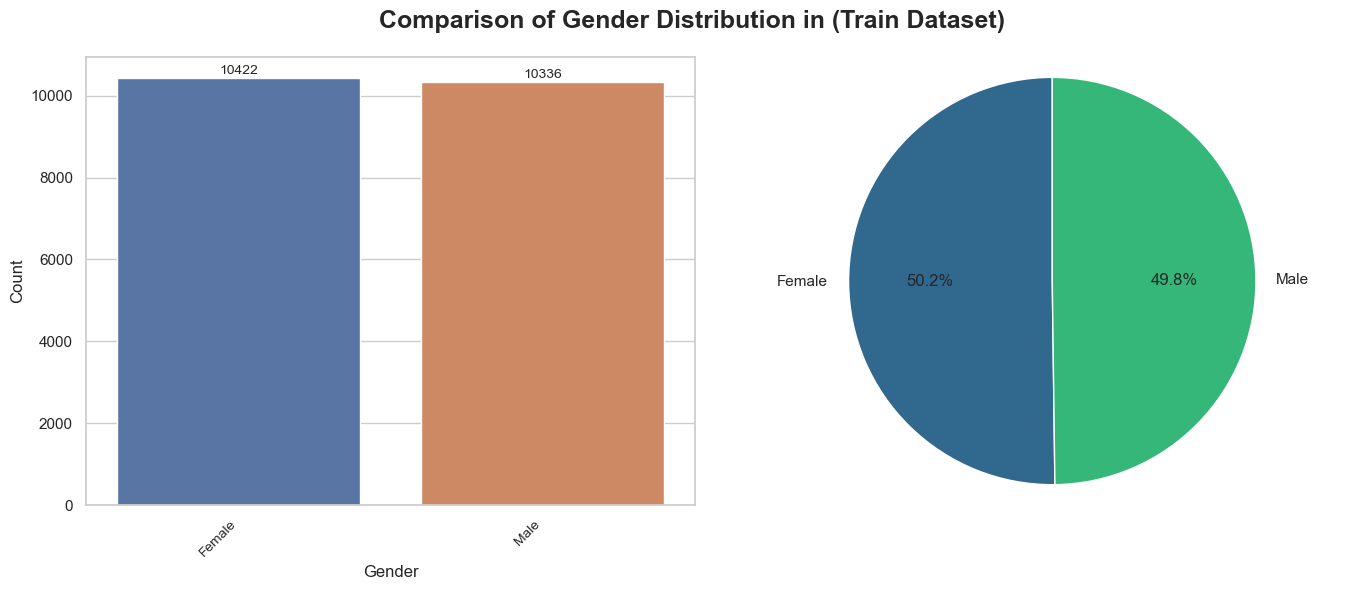

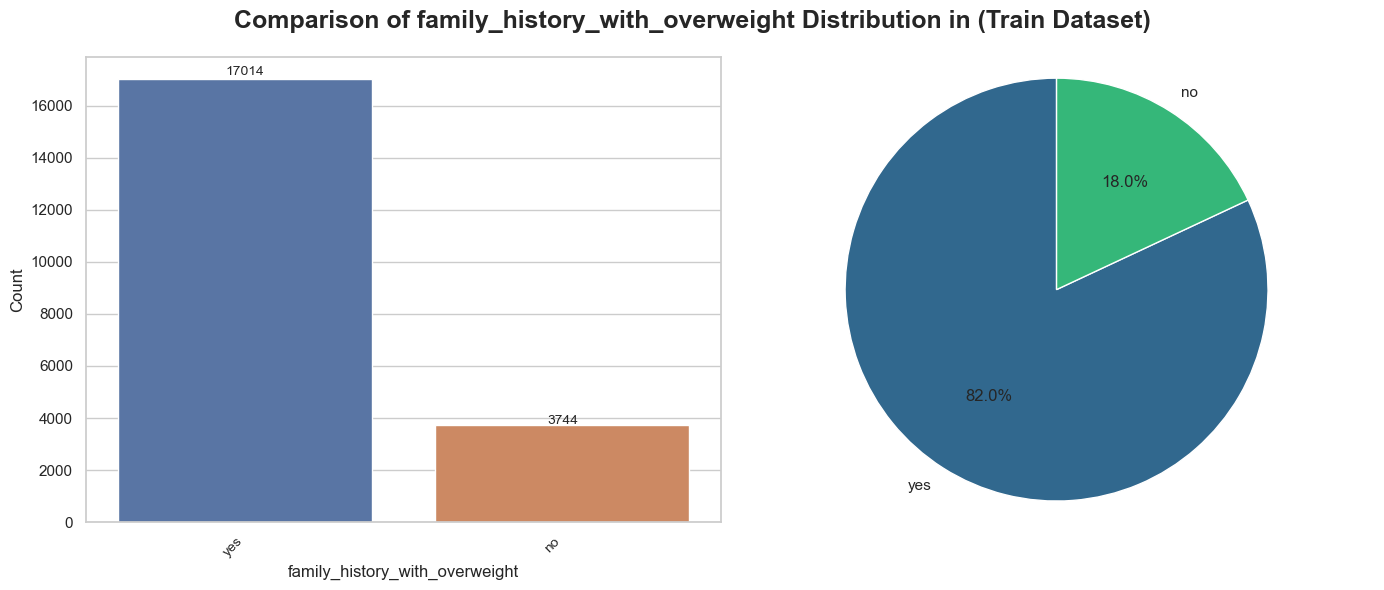

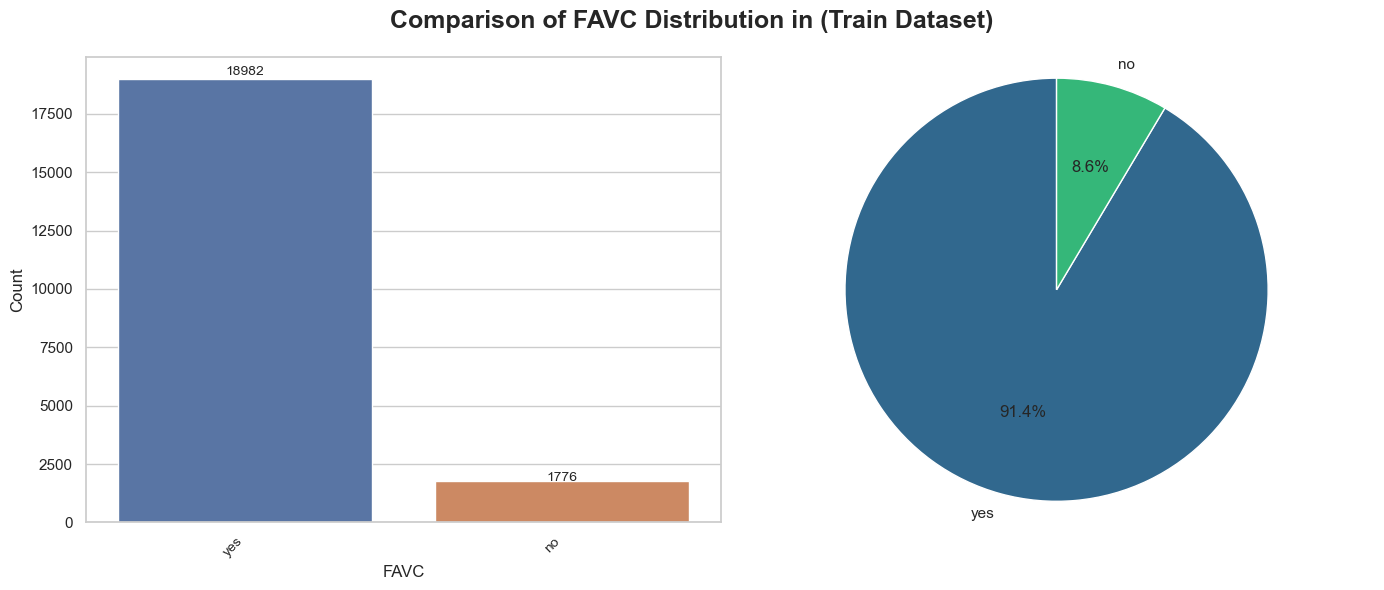

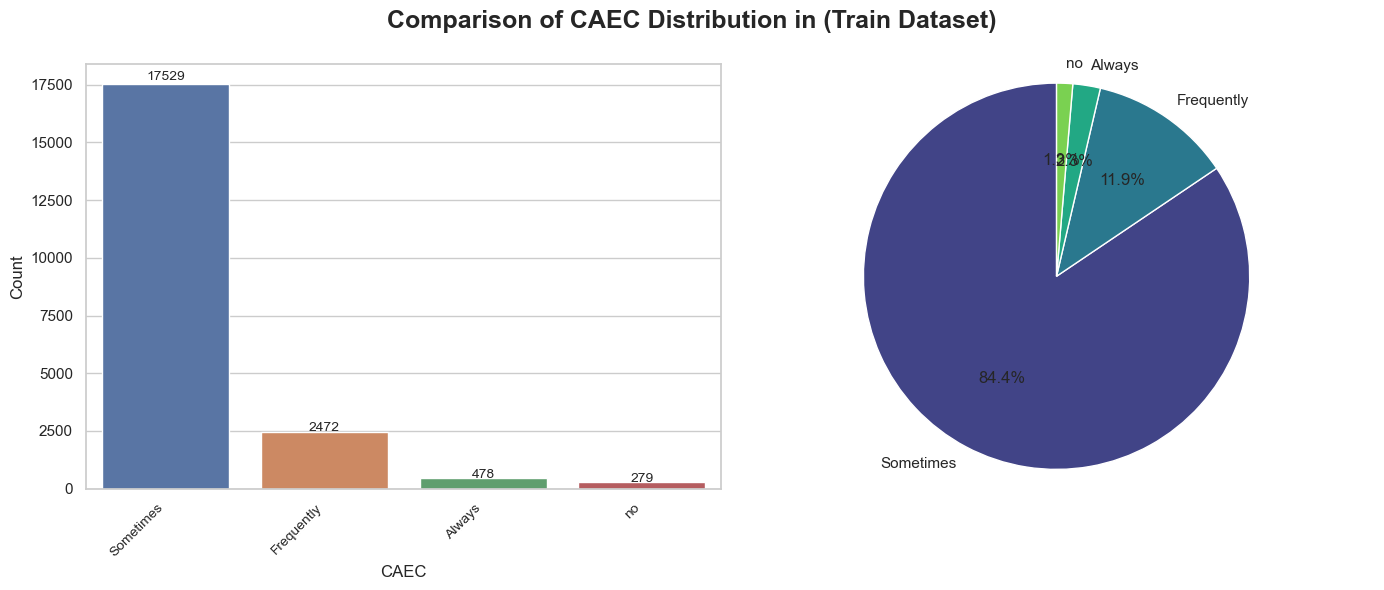

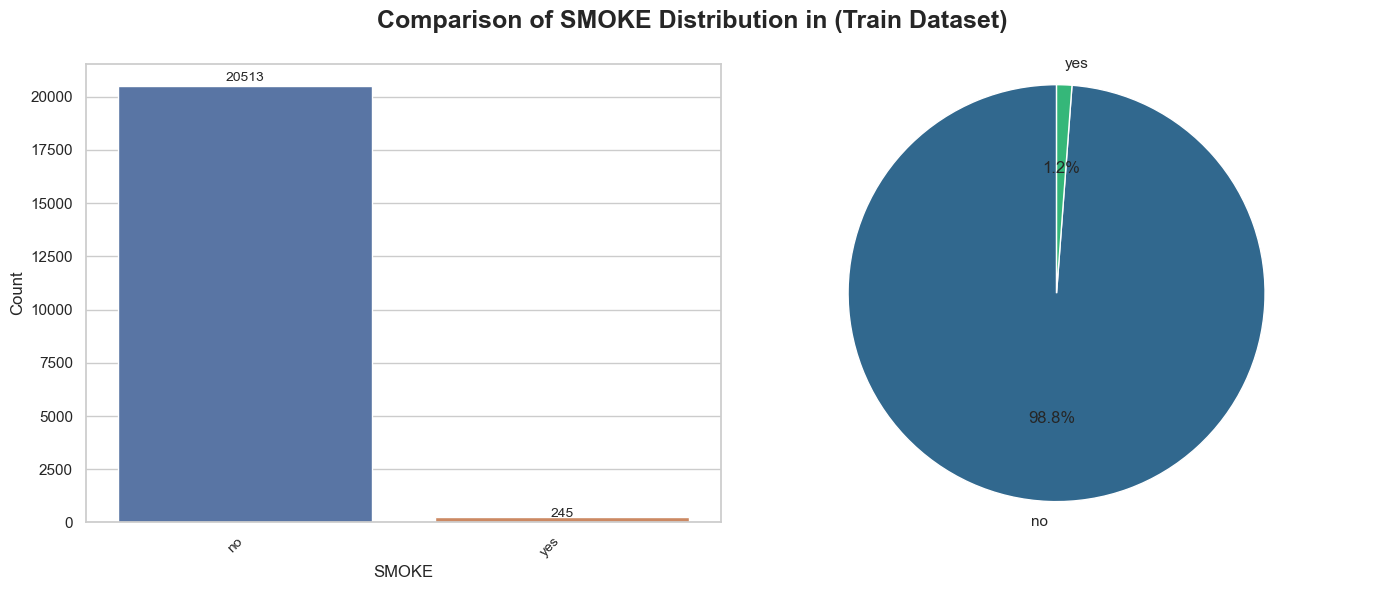

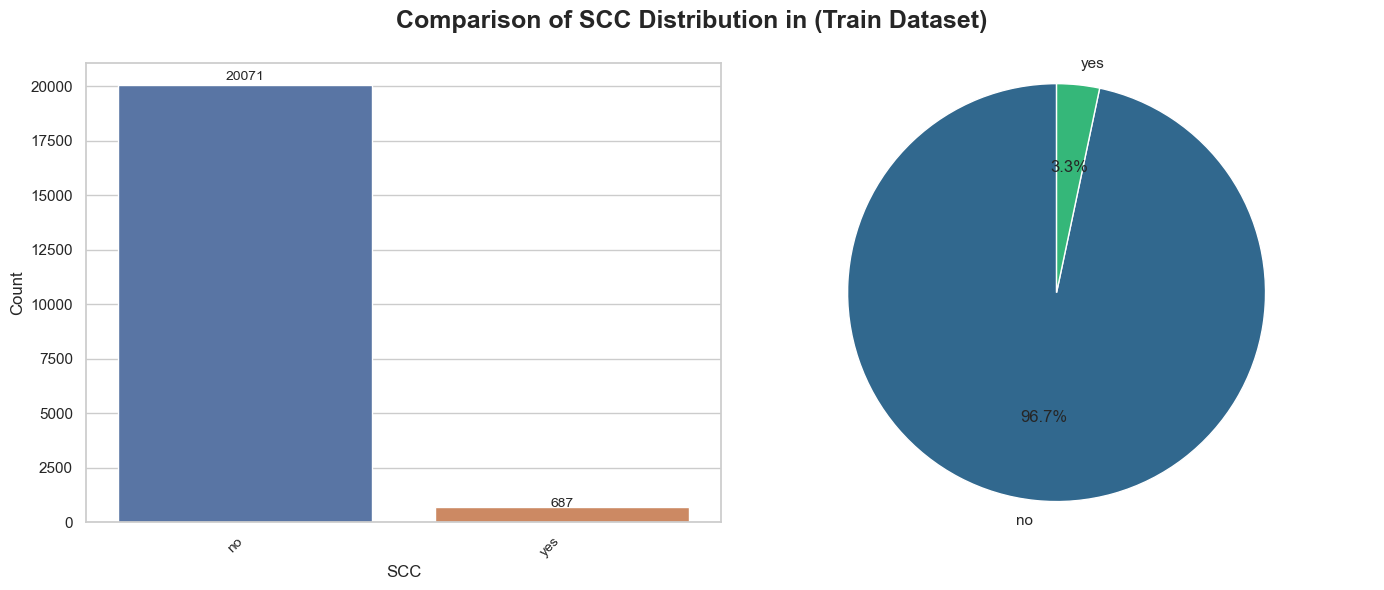

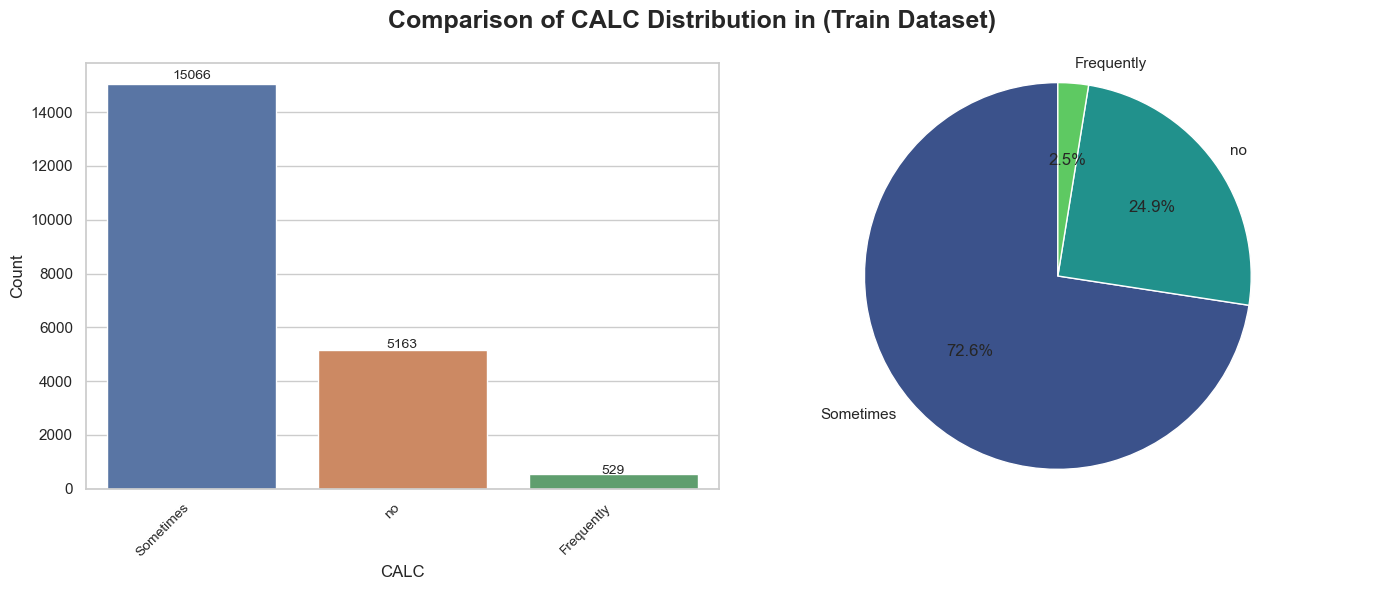

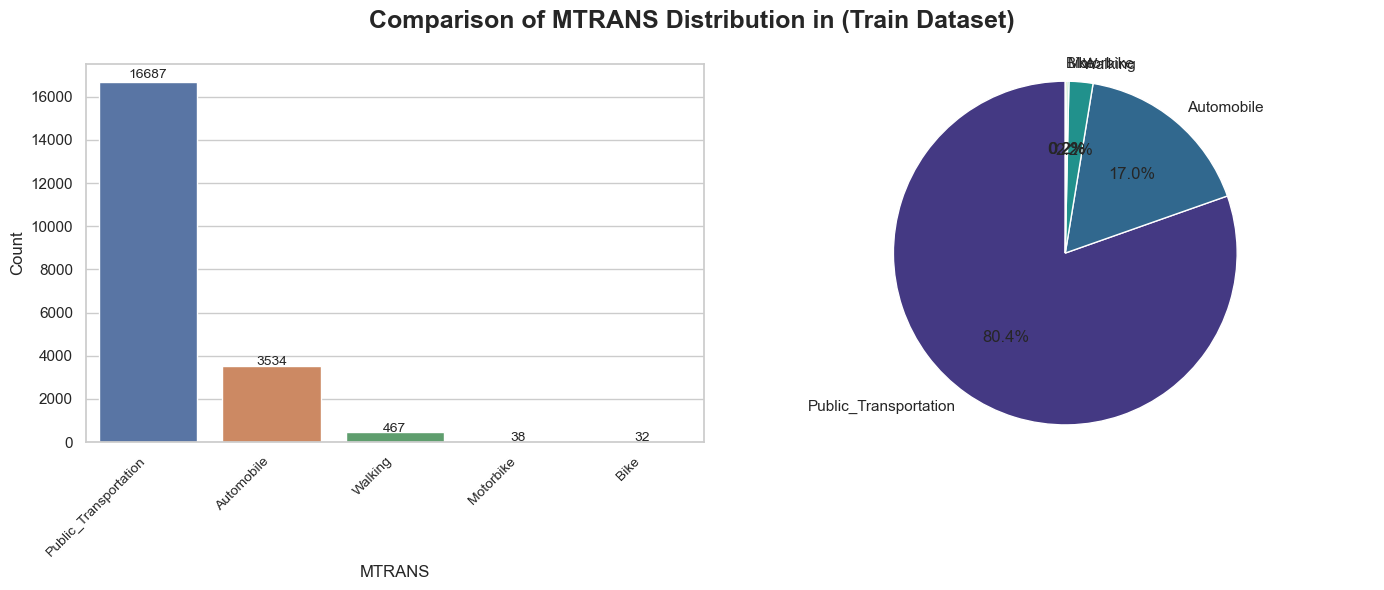

In [102]:
for cat_var in categorical_vars:
    plot_distribution(train_data,cat_var)

## Plotting Histograms and Density Plots for Continuous Variables

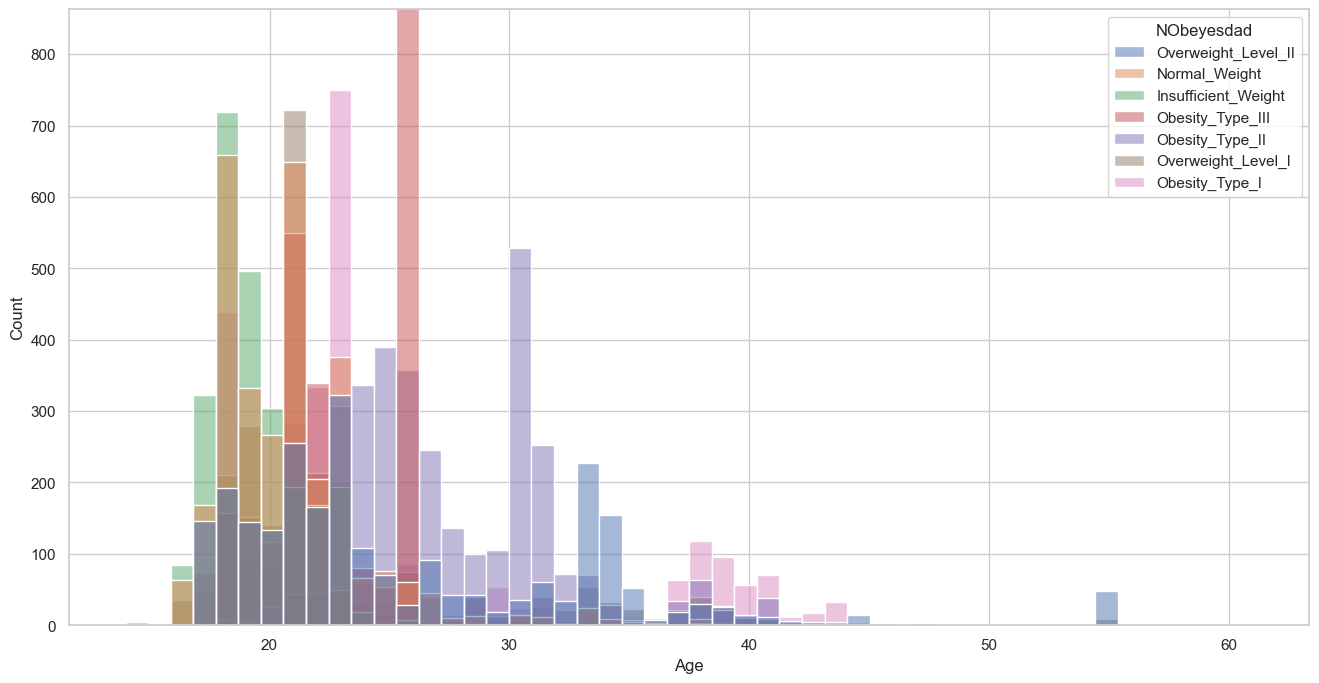

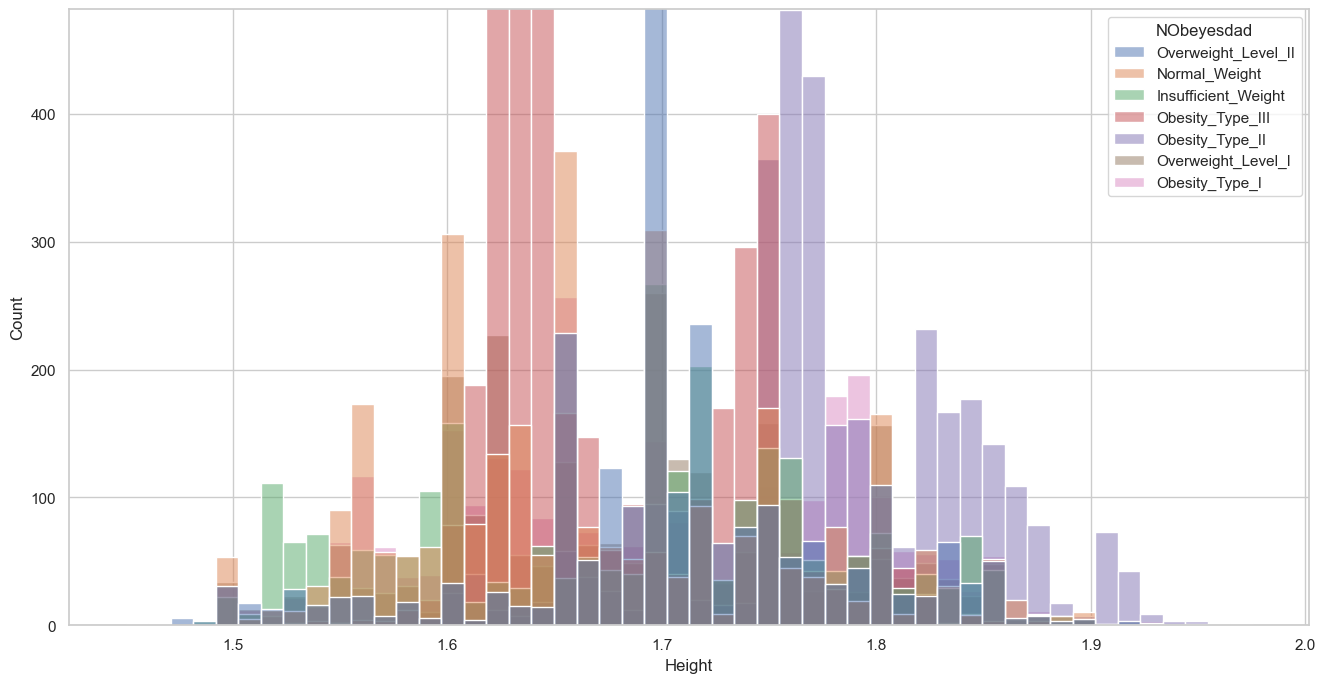

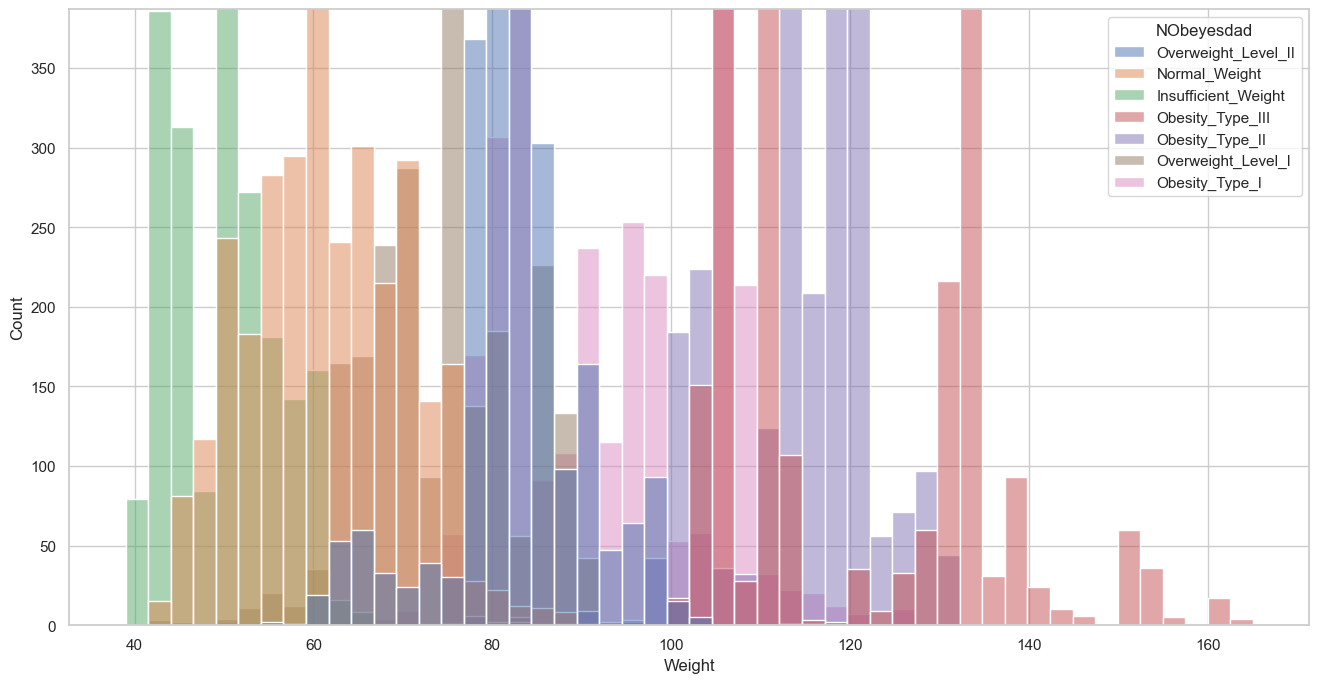

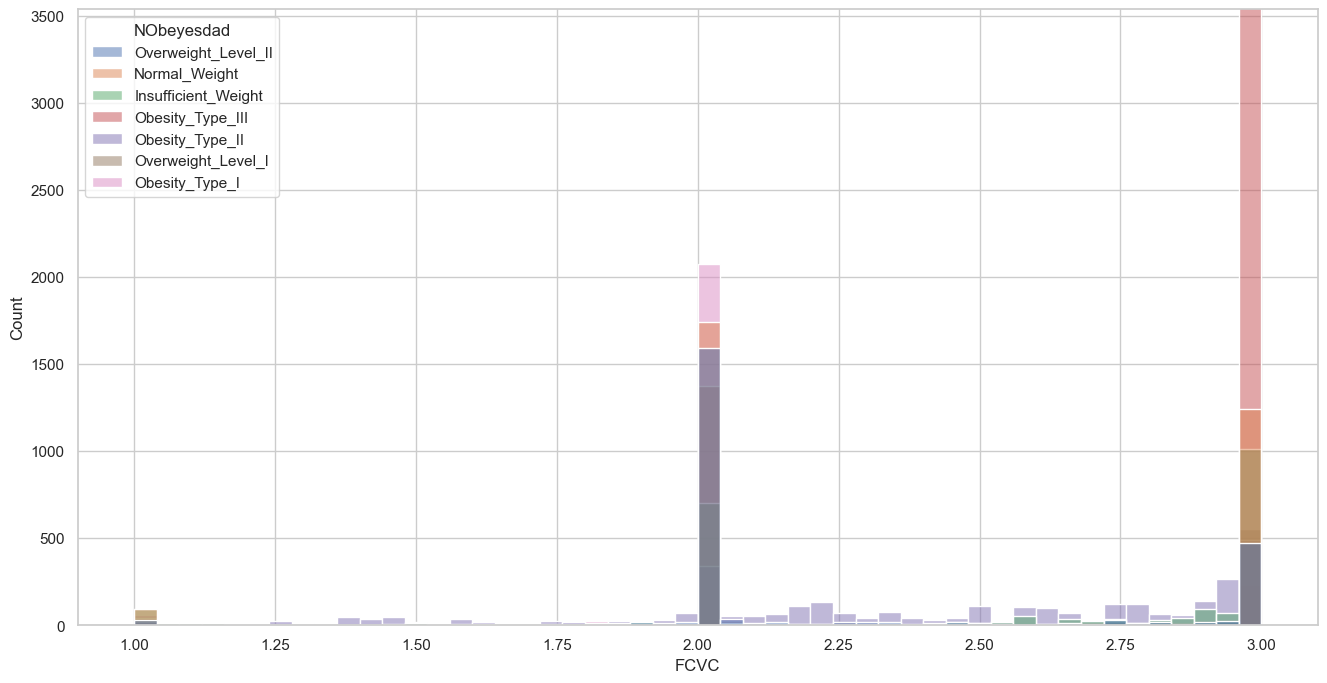

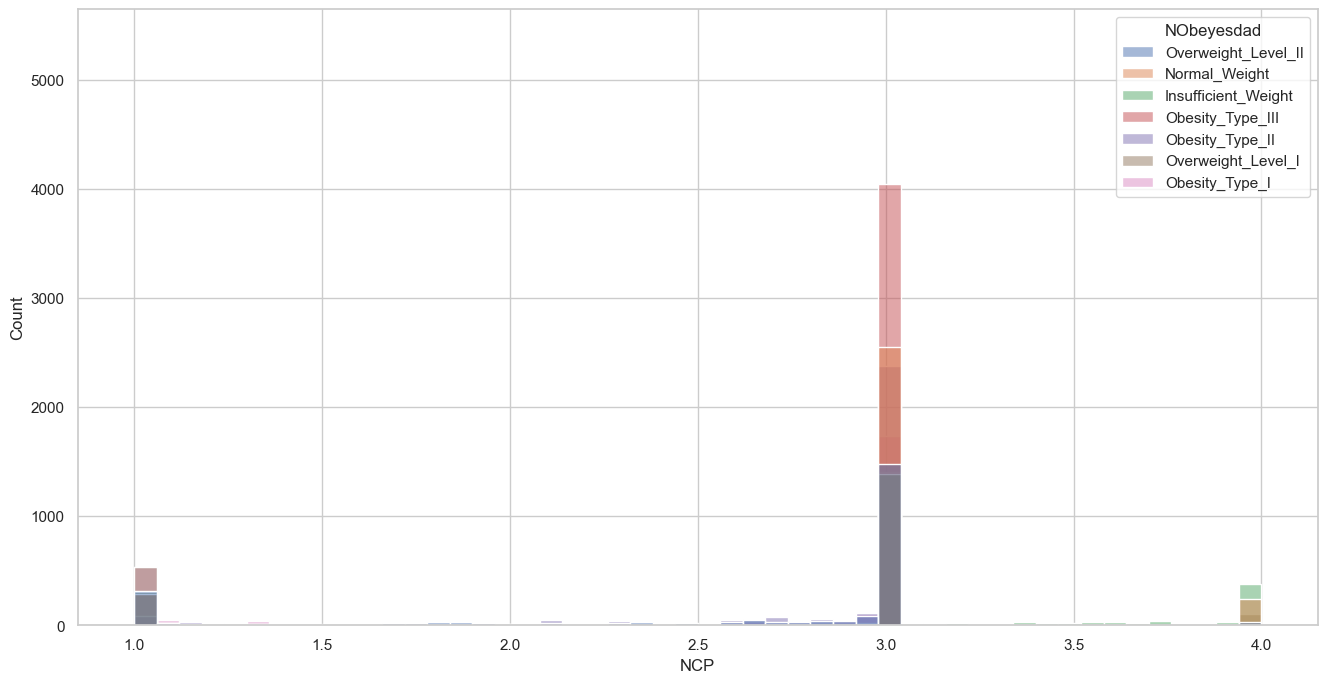

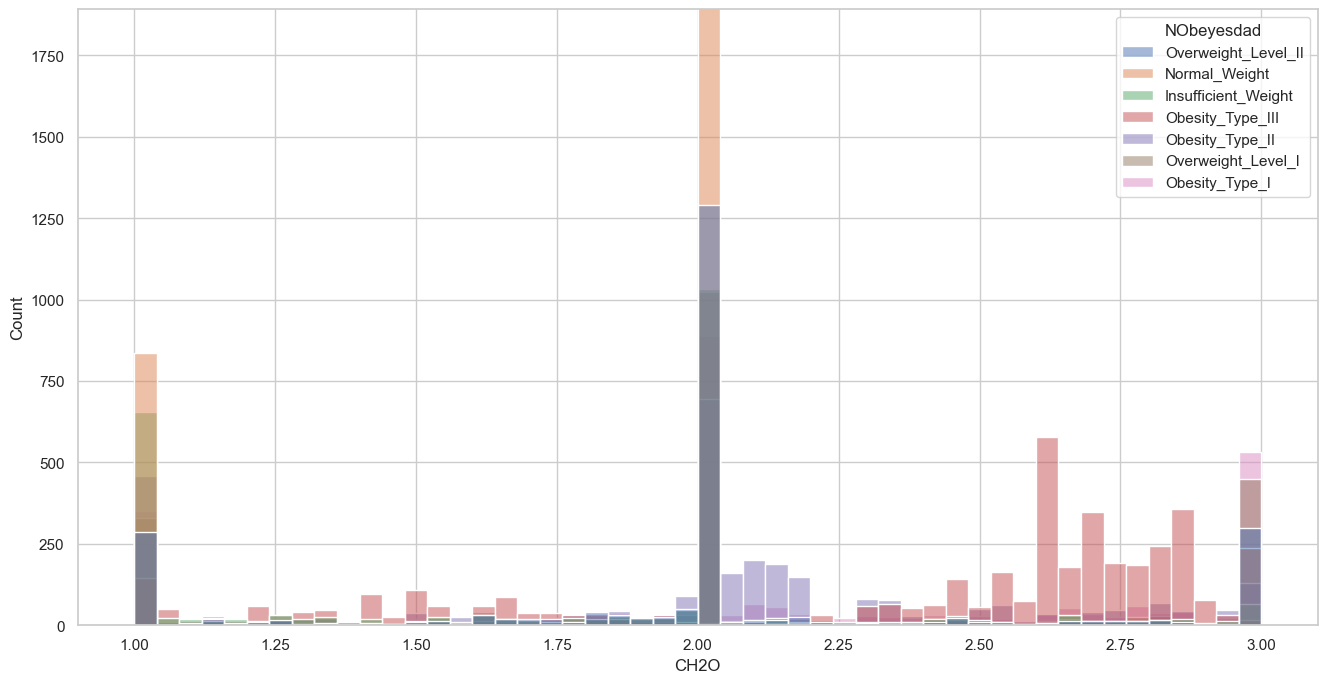

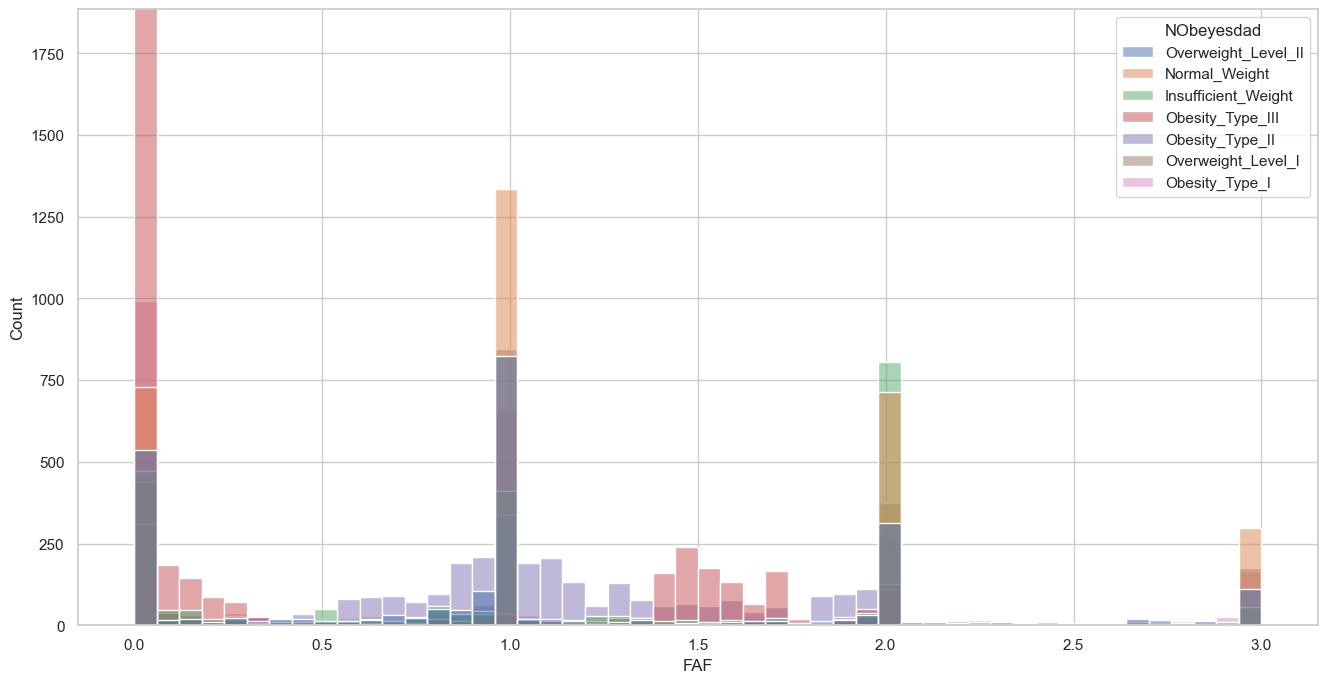

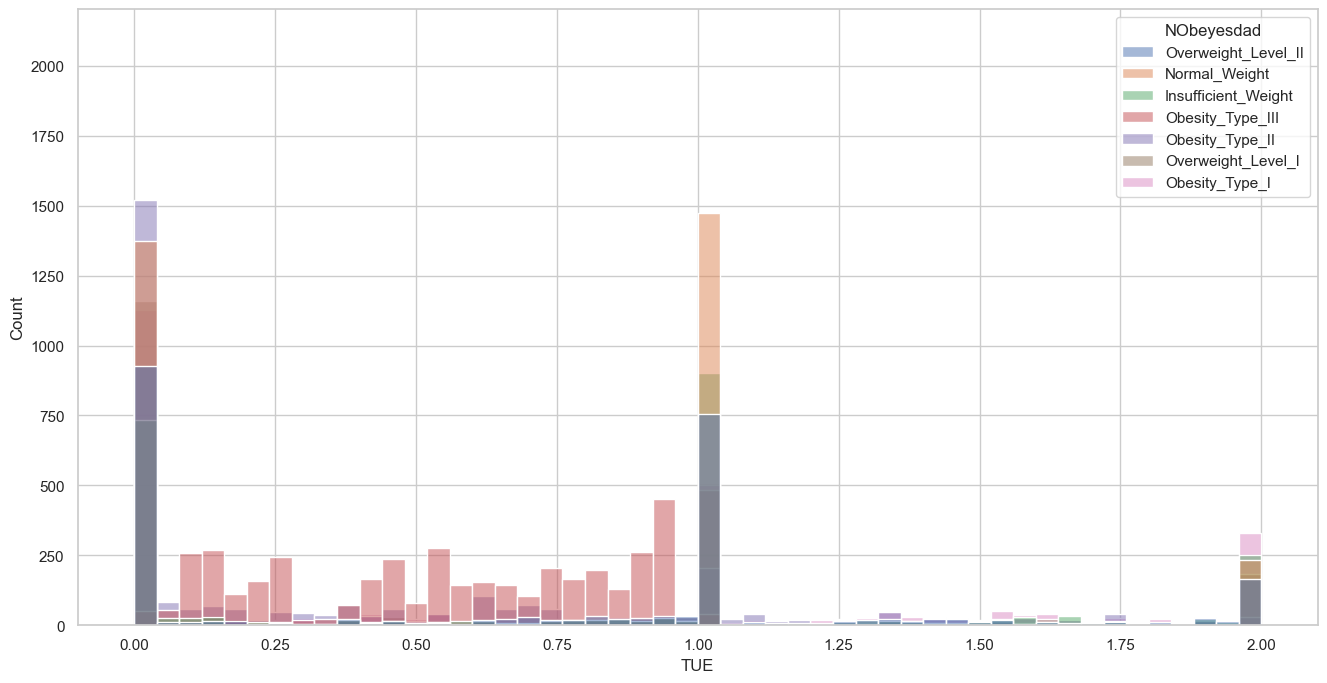

In [123]:
def plot_hist_dense(df,columns):
    for col in columns:
        fig,ax=plt.subplots(figsize=(16,8))
        fig=sns.histplot(data=df,x=col,kde=False,bins=50,hue='NObeyesdad',ax=ax) # ax=ax to plot on the same axis
        plt.ylim(0,int(np.std(df[col].value_counts().values)*10))
        plt.show()

plot_hist_dense(train_data,continuous_vars)

## Concatenate Train Data with Original

In [130]:
train=pd.concat([train_data,original_data],axis=0).drop('id',axis=1).drop_duplicates(keep='first')
test=test_data.drop('id',axis=1)


print(f"Original train shape: {train_data.shape}\nNew Train shape: {train.shape}\n")
train.head()

Original train shape: (20758, 18)
New Train shape: (22845, 17)



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## One Hot Encoding Categirical Variables



In [132]:
train=pd.get_dummies(train,columns=categorical_vars) # One hot encoding creates a new column for each distinct value for original column
test=pd.get_dummies(test,columns=categorical_vars)

In [134]:
train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


## Splitting Data in to Training and Test sets

In [135]:
X=train.drop(columns=['NObeyesdad'],axis=1)
y=train['NObeyesdad']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Print the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18276, 31)
X_test shape: (4569, 31)
y_train shape: (18276,)
y_test shape: (4569,)


## Optimizing Hyperparameters for LGBMClassifier using Optuna

In [136]:
# define the objective function for optuna optimization
def objective(trial,X_train,X_test,y_train,y_test):
    # define Hyperparameters to be optimized
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.04),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }
    # create an instance of the model
    lgbm_classifier=LGBMClassifier(**param)

    # fit the classifier on train data
    lgbm_classifier.fit(X_train,y_train)

    # Evaluate the classifier on the test data
    score=lgbm_classifier.score(X_test,y_test)
    return score

# create a study object and optimize the objective function
study=optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial,X_train,X_test,y_train,y_test),n_trials=50)

# Get the best parameters
best_params=study.best_params

print("="*50)
print(f"Best Parameters:\n\n {best_params}")



[I 2024-02-06 15:00:22,177] A new study created in memory with name: no-name-ff23ed98-0ee9-4f1c-9d74-b5dccd2e0037
[I 2024-02-06 15:00:32,071] Trial 0 finished with value: 0.9172685489166119 and parameters: {'learning_rate': 0.021236203565420872, 'n_estimators': 591, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 45}. Best is trial 0 with value: 0.9172685489166119.
[I 2024-02-06 15:00:41,857] Trial 1 finished with value: 0.9148610199168308 and parameters: {'learning_rate': 0.028033450352296263, 'n_estimators': 542, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 13, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 17}. Best is trial 0 with value: 0.9172685489166119.
[I 2024-02-06 15:00:51,513] Trial 2 finished with value: 0.915517618734953 and parameters: {'learning_rate': 0.0191

Best Parameters:

 {'learning_rate': 0.0188721921030083, 'n_estimators': 444, 'lambda_l1': 0.011336126159144583, 'lambda_l2': 0.05419770674375116, 'max_depth': 8, 'colsample_bytree': 0.40390644416273114, 'subsample': 0.8160786536664189, 'min_child_samples': 27}


In [137]:
best_params

{'learning_rate': 0.0188721921030083,
 'n_estimators': 444,
 'lambda_l1': 0.011336126159144583,
 'lambda_l2': 0.05419770674375116,
 'max_depth': 8,
 'colsample_bytree': 0.40390644416273114,
 'subsample': 0.8160786536664189,
 'min_child_samples': 27}

In [138]:
best_params_ = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "num_class": 7,
    "learning_rate": best_params['learning_rate'],
    "n_estimators": best_params['n_estimators'],
    "lambda_l1": best_params['lambda_l1'],
    "lambda_l2": best_params['lambda_l2'],
    "max_depth": best_params['max_depth'],
    "colsample_bytree": best_params['colsample_bytree'],
    "subsample": best_params['subsample'],
    "min_child_samples": best_params['min_child_samples'],
    }

## Create an Instance of LGBM CLassifier with best Hyperparameters

In [139]:
lgbm_classifier=LGBMClassifier(**best_params_)
lgbm_classifier.fit(X_train,y_train)

y_pred=lgbm_classifier.predict(X_test)
accuracy_score(y_pred,y_test)

0.9188006128255636

In [158]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
skf=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
all_preds=[]
for train_index,val_index in skf.split(X,y):
    X_train,X_val=X.iloc[train_index],X.iloc[val_index]
    y_train,y_val=y.iloc[train_index],y.iloc[val_index]
    lgbm_classifier=LGBMClassifier(**best_params_)
    lgbm_classifier.fit(X_train,y_train)
    y_pred=lgbm_classifier.predict(X_val)
    score=accuracy_score(y_pred,y_val)
    print(f"Accuracy: {score}")
    Y_pred_test=lgbm_classifier.predict(test)
    all_preds.append(Y_pred_test)

def get_mode(arr):
    return max(set(arr), key=arr.count)

def get_mode_by_position(list_of_arrays):
    # Use zip to group elements at the same positions
    grouped_elements = zip(*list_of_arrays)
    # Apply get_mode to each group of elements
    mode_array = [get_mode(group) for group in grouped_elements]
    return mode_array

# get the mode of the predictions
final_preds=get_mode_by_position(all_preds)

# create a submission dataframe
submission=pd.DataFrame({'id':sample_submission['id'],'NObeyesdad':final_preds})
submission.to_csv('submission_mode.csv',index=False)


Accuracy: 0.9201138104618078
Accuracy: 0.9117968920989276
Accuracy: 0.9142044210987087
Accuracy: 0.9128912234624644
Accuracy: 0.9188006128255636


In [159]:
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


## Submission 

In [140]:
predictions=lgbm_classifier.predict(test)
sample_submission['NObeyesdad']=predictions
sample_submission.to_csv('LGBM_submission.csv',index=False)

Helper function

In [162]:
def get_mode(arr):
    return max(set(arr), key=arr.count)

def get_mode_by_position(list_of_arrays):
    # Use zip to group elements at the same positions
    grouped_elements = zip(*list_of_arrays)
    
    # Apply get_mode to each group of elements
    mode_array = [get_mode(group) for group in grouped_elements]
    
    return mode_array

# Test the function
arrays = [['a', 'b', 'c', 'd'], ['b', 'b', 'c', 'd'], ['a', 'b', 'd', 'd']]
mode_array = get_mode_by_position(arrays)

print(f'The mode array is {mode_array}')

The mode array is ['a', 'b', 'c', 'd']
